In [1]:
"""
Variational Quantum Eigensolver Benchmark Program - Qiskit
"""

import json
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.opflow import PauliTrotterEvolution, Suzuki
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit import *

# Noise parameters
options = { } #if Noise is None

options_noisy = { #if Noise is not None
    'plot': False,
    "thermal_factor": 1.0,
    'show_partition': False,
    "decoherence_factor": 0.9,
    "depolarization_factor": 0.9,
    "bell_depolarization_factor": 0.9,
    "decay_factor": 0.9,
    "rotation_error": {'rx':[1.0, 0.0], 'ry':[1.0, 0.0], 'rz':[1.0, 0.0]},
    "tsp_model_error": [1.0, 0.0],
}

# Selection of basis gate set for transpilation
# Note: selector 1 is a hardware agnostic gate set
basis_selector = 1
basis_gates_array = [
    [],
    ['rx', 'ry', 'rz', 'cx'],       # a common basis set, default
    ['cx', 'rz', 'sx', 'x'],        # IBM default basis set
    ['rx', 'ry', 'rxx'],            # IonQ default basis set
    ['h', 'p', 'cx'],               # another common basis set
    ['u', 'cx']                     # general unitaries basis gates
]


np.random.seed(0)

# saved circuits for display
QC_ = None
Hf_ = None
CO_ = None


In [2]:
################### Circuit Definition #######################################

# Construct a Qiskit circuit for VQE Energy evaluation with UCCSD ansatz
# param: n_spin_orbs - The number of spin orbitals.
# return: return a Qiskit circuit for this VQE ansatz
def VQEEnergy(n_spin_orbs, na, nb, circuit_id=0, method=1):

    # number of alpha spin orbitals
    norb_a = int(n_spin_orbs / 2)

    # construct the Hamiltonian
    qubit_op = ReadHamiltonian(n_spin_orbs)

    # allocate qubits
    num_qubits = n_spin_orbs

    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr, name=f"vqe-ansatz({method})-{num_qubits}-{circuit_id}")

    # initialize the HF state
    Hf = HartreeFock(num_qubits, na, nb)
    qc.append(Hf, qr)

    # form the list of single and double excitations 
    excitationList = []
    for occ_a in range(na):
        for vir_a in range(na, norb_a):
            excitationList.append((occ_a, vir_a))

    for occ_b in range(norb_a, norb_a+nb):
        for vir_b in range(norb_a+nb, n_spin_orbs):
            excitationList.append((occ_b, vir_b))

    for occ_a in range(na):
        for vir_a in range(na, norb_a):
            for occ_b in range(norb_a, norb_a+nb):
                for vir_b in range(norb_a+nb, n_spin_orbs):
                    excitationList.append((occ_a, vir_a, occ_b, vir_b))

    # get cluster operators in Paulis
    pauli_list = readPauliExcitation(n_spin_orbs, circuit_id)

    # loop over the Pauli operators
    for index, PauliOp in enumerate(pauli_list):
        # get circuit for exp(-iP)
        cluster_qc = ClusterOperatorCircuit(PauliOp, excitationList[index])

        # add to ansatz
        qc.append(cluster_qc, [i for i in range(cluster_qc.num_qubits)])
        
    # method 1, only compute the last term in the Hamiltonian
    if method == 1:
        # last term in Hamiltonian
        qc_with_mea, is_diag = ExpectationCircuit(qc, qubit_op[1], num_qubits)

        # return the circuit
        return qc_with_mea

    # now we need to add the measurement parts to the circuit
    # circuit list 
    qc_list = []
    diag = []
    off_diag = []
    global normalization
    normalization = 0.0

    # add the first non-identity term
    identity_qc = qc.copy()
    identity_qc.measure_all()
    qc_list.append(identity_qc) # add to circuit list
    diag.append(qubit_op[1])
    normalization += abs(qubit_op[1].coeffs[0]) # add to normalization factor
    diag_coeff = abs(qubit_op[1].coeffs[0]) # add to coefficients of diagonal terms

    # loop over rest of terms 
    for index, p in enumerate(qubit_op[2:]):
        
        # get the circuit with expectation measurements
        qc_with_mea, is_diag = ExpectationCircuit(qc, p, num_qubits)

        # accumulate normalization 
        normalization += abs(p.coeffs[0])

        # add to circuit list if non-diagonal
        if not is_diag:
            qc_list.append(qc_with_mea)
        else:
            diag_coeff += abs(p.coeffs[0])

        # diagonal term
        if is_diag:
            diag.append(p)
        # off-diagonal term
        else:
            off_diag.append(p)

    # modify the name of diagonal circuit
    qc_list[0].name = qubit_op[1].primitive.to_list()[0][0] + " " + str(np.real(diag_coeff))
    normalization /= len(qc_list)
    return qc_list

# Function that constructs the circuit for a given cluster operator
def ClusterOperatorCircuit(pauli_op, excitationIndex):
    
    # compute exp(-iP)
    exp_ip = pauli_op.exp_i()

    # Trotter approximation
    qc_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert(exp_ip)

    # convert to circuit
    qc = qc_op.to_circuit(); qc.name = f'Cluster Op {excitationIndex}'
    global CO_
    if CO_ == None or qc.num_qubits <= 4:
        if qc.num_qubits < 7: CO_ = qc

    # return this circuit
    return qc


# Function that adds expectation measurements to the raw circuits
def ExpectationCircuit(qc, pauli, nqubit, method=2):

    # copy the unrotated circuit
    raw_qc = qc.copy()

    # whether this term is diagonal
    is_diag = True

    # primitive Pauli string
    PauliString = pauli.primitive.to_list()[0][0]

    # coefficient
    coeff = pauli.coeffs[0]

    # basis rotation
    for i, p in enumerate(PauliString):
    
        target_qubit = nqubit - i - 1 
        if (p == "X"):
            is_diag = False
            raw_qc.h(target_qubit)
        elif (p == "Y"):
            raw_qc.sdg(target_qubit)
            raw_qc.h(target_qubit)
            is_diag = False

    # perform measurements
    raw_qc.measure_all()

    # name of this circuit
    raw_qc.name = PauliString + " " + str(np.real(coeff))

    # save circuit
    global QC_
    if QC_ == None or nqubit <= 4:
        if nqubit < 7: QC_ = raw_qc

    return raw_qc, is_diag

# Function that implements the Hartree-Fock state 
def HartreeFock(norb, na, nb):

    # initialize the quantum circuit
    qc = QuantumCircuit(norb, name="Hf")
    
    # alpha electrons
    for ia in range(na):
        qc.x(ia)

    # beta electrons
    for ib in range(nb):
        qc.x(ib+int(norb/2))

    # Save smaller circuit
    global Hf_
    if Hf_ == None or norb <= 4:
        if norb < 7: Hf_ = qc

    # return the circuit
    return qc

################ Helper Functions

# Function that converts a list of single and double excitation operators to Pauli operators
def readPauliExcitation(norb, circuit_id=0):

    # load pre-computed data
    filename = os.path.join(f'ansatzes/{norb}_qubit_{circuit_id}.txt')
    with open(filename) as f:
        data = f.read()
    ansatz_dict = json.loads(data)

    # initialize Pauli list
    pauli_list = []

    # current coefficients 
    cur_coeff = 1e5

    # current Pauli list 
    cur_list = []

    # loop over excitations
    for ext in ansatz_dict:

        if cur_coeff > 1e4:
            cur_coeff = ansatz_dict[ext]
            cur_list = [(ext, ansatz_dict[ext])]
        elif abs(abs(ansatz_dict[ext]) - abs(cur_coeff)) > 1e-4:
            pauli_list.append(PauliSumOp.from_list(cur_list))
            cur_coeff = ansatz_dict[ext]
            cur_list = [(ext, ansatz_dict[ext])]
        else:
            cur_list.append((ext, ansatz_dict[ext]))
        
    # add the last term
    pauli_list.append(PauliSumOp.from_list(cur_list))

    # return Pauli list
    return pauli_list

# Get the Hamiltonian by reading in pre-computed file
def ReadHamiltonian(nqubit):

    # load pre-computed data
    filename = os.path.join( f'Hamiltonians/{nqubit}_qubit.txt')
    with open(filename) as f:
        data = f.read()
    ham_dict = json.loads(data)

    # pauli list 
    pauli_list = []
    for p in ham_dict:
        pauli_list.append( (p, ham_dict[p]) )

    # build Hamiltonian
    ham = PauliSumOp.from_list(pauli_list)

    # return Hamiltonian
    return ham

In [3]:
############################################
# DATA ANALYSIS - FIDELITY CALCULATIONS

## Uniform distribution function commonly used
def rescale_fidelity(fidelity, floor_fidelity, new_floor_fidelity):
    """
    Linearly rescales our fidelities to allow comparisons of fidelities across benchmarks
    
    fidelity: raw fidelity to rescale
    floor_fidelity: threshold fidelity which is equivalent to random guessing
    new_floor_fidelity: what we rescale the floor_fidelity to 

    Ex, with floor_fidelity = 0.25, new_floor_fidelity = 0.0:
        1 -> 1;
        0.25 -> 0;
        0.5 -> 0.3333;
    """
    rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
    
    # ensure fidelity is within bounds (0, 1)
    if rescaled_fidelity < 0:
        rescaled_fidelity = 0.0
    if rescaled_fidelity > 1:
        rescaled_fidelity = 1.0
    
    return rescaled_fidelity
    
def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist                

### Analysis methods to be expanded and eventually compiled into a separate analysis.py file
import math, functools

def hellinger_fidelity_with_expected(p, q):
    """ p: result distribution, may be passed as a counts distribution
        q: the expected distribution to be compared against

    References:
        `Hellinger Distance @ wikipedia <https://en.wikipedia.org/wiki/Hellinger_distance>`_
        Qiskit Hellinger Fidelity Function
    """
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    if q_sum == 0:
        print("ERROR: polarization_fidelity(), expected distribution is invalid, all counts equal to 0")
        return 0

    p_normed = {}
    for key, val in p.items():
        p_normed[key] = val/p_sum
        # if p_sum != 0:
        #     p_normed[key] = val/p_sum
        # else:
        #     p_normed[key] = 0

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())
    
    # in some situations (error mitigation) this can go negative, use abs value
    if total < 0:
        print(f"WARNING: using absolute value in fidelity calculation")
        total = abs(total)
        
    dist = np.sqrt(total)/np.sqrt(2)
    fidelity = (1-dist**2)**2

    return fidelity

def polarization_fidelity(counts, correct_dist, thermal_dist=None):
    """
    Combines Hellinger fidelity and polarization rescaling into fidelity calculation
    used in every benchmark

    counts: the measurement outcomes after `num_shots` algorithm runs
    correct_dist: the distribution we expect to get for the algorithm running perfectly
    thermal_dist: optional distribution to pass in distribution from a uniform
                  superposition over all states. If `None`: generated as 
                  `uniform_dist` with the same qubits as in `counts`
                  
    returns both polarization fidelity and the hellinger fidelity

    Polarization from: `https://arxiv.org/abs/2008.11294v1`
    """
    #print("in polarization fidelity:",correct_dist)
    num_measured_qubits = len(list(correct_dist.keys())[0])
    print(num_measured_qubits)
    
    counts = {k.zfill(num_measured_qubits): v for k, v in counts.items()}
    
    # calculate hellinger fidelity between measured expectation values and correct distribution
    hf_fidelity = hellinger_fidelity_with_expected(counts,correct_dist)
    
    # to limit cpu and memory utilization, skip noise correction if more than 16 measured qubits
    if num_measured_qubits > 16:
        return { 'fidelity':hf_fidelity, 'hf_fidelity':hf_fidelity }

    # if not provided, generate thermal dist based on number of qubits
    if thermal_dist == None:
        thermal_dist = uniform_dist(num_measured_qubits)

    # set our fidelity rescaling value as the hellinger fidelity for a depolarized state
    floor_fidelity = hellinger_fidelity_with_expected(thermal_dist, correct_dist)

    # rescale fidelity result so uniform superposition (random guessing) returns fidelity
    # rescaled to 0 to provide a better measure of success of the algorithm (polarization)
    new_floor_fidelity = 0
    fidelity = rescale_fidelity(hf_fidelity, floor_fidelity, new_floor_fidelity)

    return { 'fidelity':fidelity, 'hf_fidelity':hf_fidelity }

In [4]:
# Function to calculate circuit depth
def calculate_circuit_depth(qc):
    # Calculate the depth of the circuit
    depth = qc.depth()
    return depth

def calculate_transpiled_depth(qc,basis_selector):
    # use either the backend or one of the basis gate sets
    if basis_selector == 0:
        qc = transpile(qc, backend)
        
    else:
        basis_gates = basis_gates_array[basis_selector]
        qc = transpile(qc, basis_gates=basis_gates, seed_transpiler=0)
    transpiled_depth = qc.depth()
    return transpiled_depth

def plot_data(fidelity_data, Hf_fidelity_data, title):
    avg_fidelity_means = []
    avg_Hf_fidelity_means = []
    avg_num_qubits_values = list(fidelity_data.keys())
    print("avg_num_qubits_values",avg_num_qubits_values)
    # Calculate the average fidelity and Hamming fidelity for each unique number of qubits
    for num_qubits in avg_num_qubits_values:
        avg_fidelity = np.average(fidelity_data[num_qubits])
        avg_fidelity_means.append(avg_fidelity)

        avg_Hf_fidelity = np.mean(Hf_fidelity_data[num_qubits])
        avg_Hf_fidelity_means.append(avg_Hf_fidelity)
    
    

    # Plot the data
    x = np.arange(len(avg_num_qubits_values))
    
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects2 =ax.bar(x, avg_Hf_fidelity_means, width=0.4, label='Hellinger Fidelity',color="magenta")
    rects1 = ax.bar(x, avg_fidelity_means, width=0.2, label='Normalized Fidelity', color="blue")
    
    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel('Average Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(avg_num_qubits_values)
    ax.legend()
    
    # Add labels to the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.5f}'.format(height),  # Formatting to two decimal places
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.show()
    # print(fidelity_data)
    # print(Hf_fidelity_data)
    # print(avg_fidelity_means)
    # print(avg_Hf_fidelity_means)

backend = BasicAer.get_backend('dm_simulator')

************
Executing [3] circuits with num_qubits = 4
qc of 4 qubits of type <class 'type'>
        ┌─────┐┌────────────────────┐┌────────────────────┐»
  q0_0: ┤3    ├┤3                   ├┤3                   ├»
        │     ││                    ││                    │»
  q0_1: ┤2    ├┤2                   ├┤2                   ├»
        │  Hf ││  Cluster Op (0, 1) ││  Cluster Op (2, 3) │»
  q0_2: ┤1    ├┤1                   ├┤1                   ├»
        │     ││                    ││                    │»
  q0_3: ┤0    ├┤0                   ├┤0                   ├»
        └─────┘└────────────────────┘└────────────────────┘»
meas: 4/═══════════════════════════════════════════════════»
                                                           »
«        ┌──────────────────────────┐ ░          ┌─┐
«  q0_0: ┤3                         ├─░──────────┤M├
«        │                          │ ░       ┌─┐└╥┘
«  q0_1: ┤2                         ├─░───────┤M├─╫─
«        │  Cluster Op 

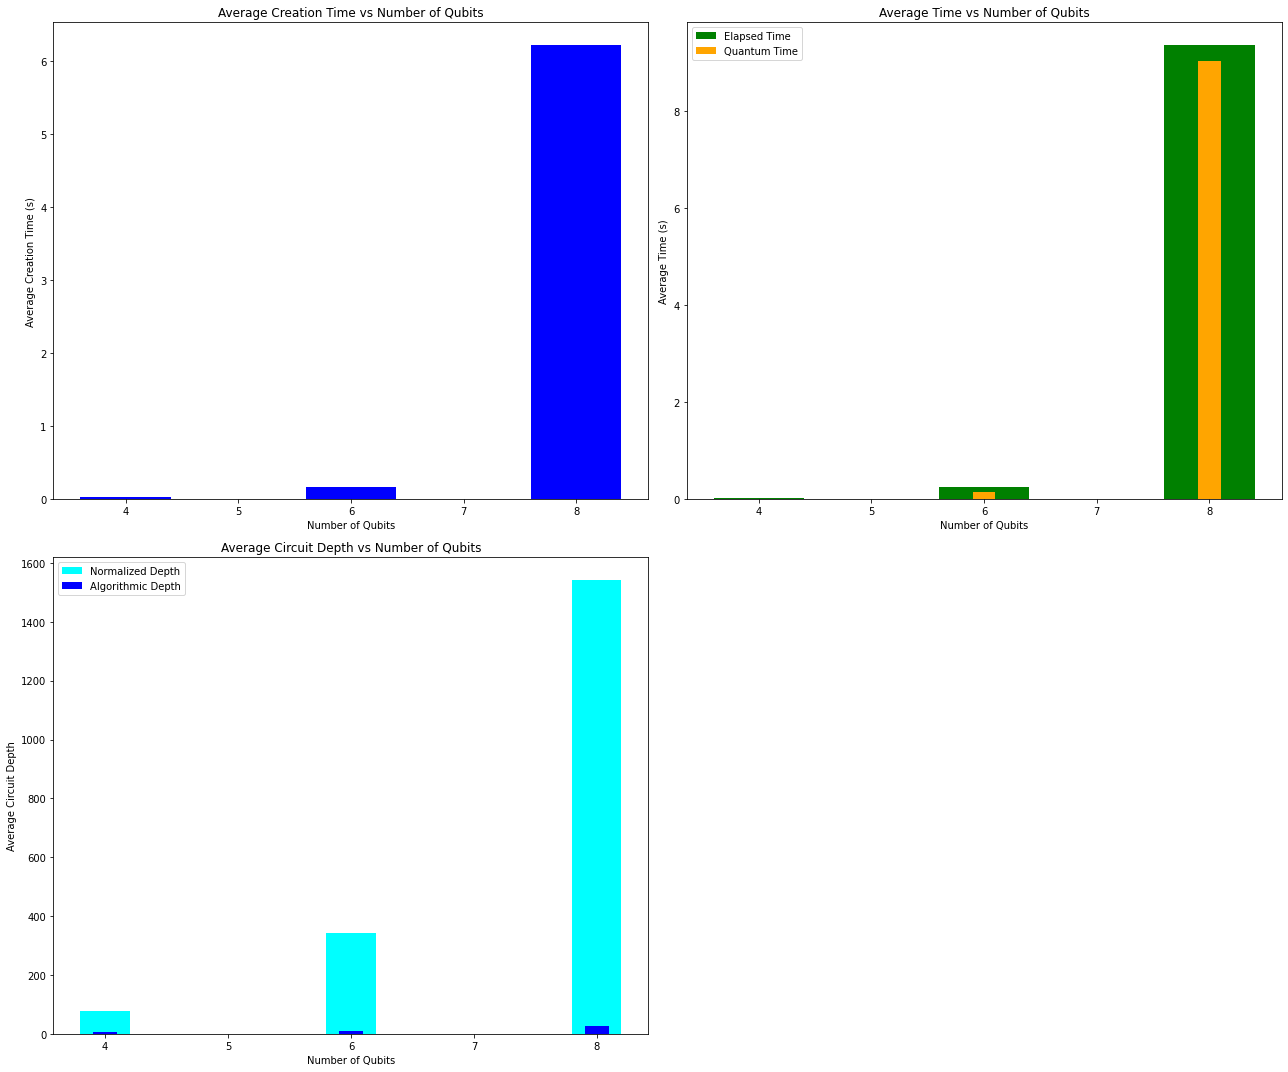

avg_num_qubits_values [4, 6, 8]


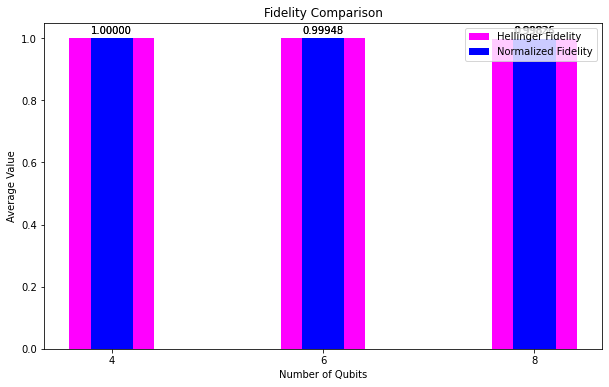

In [5]:
################ Benchmark Loop

# Max qubits must be 12 since the referenced files only go to 12 qubits
MAX_QUBITS = 12

# Execute program with default parameters
def run(min_qubits=4, max_qubits=8, skip_qubits=1,max_circuits=3, num_shots=4092, method=1):

    #print(f"{benchmark_name} ({method}) Benchmark Program - Qiskit") 

    max_qubits = max(max_qubits, min_qubits)        # max must be >= min

    # validate parameters (smallest circuit is 4 qubits and largest is 10 qubitts)
    max_qubits = min(max_qubits, MAX_QUBITS)
    min_qubits = min(max(4, min_qubits), max_qubits)
    if min_qubits % 2 == 1: min_qubits += 1  # min_qubits must be even
    skip_qubits = max(1, skip_qubits)
    
    if method == 2: max_circuits = 1

    if max_qubits < 4:
        print(f"Max number of qubits {max_qubits} is too low to run method {method} of VQE algorithm")
        return

    global max_ckts
    max_ckts = max_circuits

    creation_times = []
    elapsed_times = []
    quantum_times = []
    circuit_depths = []
    transpiled_depths = []
    fidelity_data = {}
    Hf_fidelity_data = {}

    global min_qbits,max_qbits,skp_qubits

    min_qbits = min_qubits
    max_qbits = max_qubits
    skp_qubits = skip_qubits

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for input_size in range(min_qubits, max_qubits + 1, 2):
        num_qubits = input_size 
        # reset random seed
        np.random.seed(0)

        fidelity_data[num_qubits] = []
        Hf_fidelity_data[num_qubits] = []

        # determine the number of circuits to execute for this group
        num_circuits = min(3, max_circuits)

        num_qubits = input_size

        # decides number of electrons
        na = int(num_qubits/4)
        nb = int(num_qubits/4)

        # random seed
        np.random.seed(0)

        # create the circuit for given qubit size and simulation parameters, store time metric
        ts = time.time()

        # circuit list 
        qc_list = []

        # Method 1 (default)
        if method == 1:
            # loop over circuits
            for circuit_id in range(num_circuits):

                # construct circuit 
                qc_single = VQEEnergy(num_qubits, na, nb, circuit_id, method).reverse_bits()               
                qc_single.name = qc_single.name + " " + str(circuit_id) 

                # add to list 
                qc_list.append(qc_single)
        # method 2
        elif method == 2:

            # construct all circuits
            qc_list = VQEEnergy(num_qubits, na, nb, 0, method).reverse_bits()

        print(f"************\nExecuting [{len(qc_list)}] circuits with num_qubits = {num_qubits}")

        for qc in qc_list:

            # get circuit id
            if method == 1:
                circuit_id = qc.name.split()[2]
            else:
                circuit_id = qc.name.split()[0]

            # record creation time
            creation_time = time.time() - ts
            creation_times.append(creation_time)
            print(f"qc of {num_qubits} qubits of type {type}")
            print(qc)

            # Calculate circuit depth
            depth = calculate_circuit_depth(qc)
            circuit_depths.append(depth)

            # collapse the sub-circuits used in this benchmark (for qiskit)
            qc = qc.decompose()

            # Calculate transpiled circuit depth
            transpiled_depth = calculate_transpiled_depth(qc,basis_selector)
            transpiled_depths.append(transpiled_depth)
            
            #execution
            ts = time.time()
            job = execute(qc, backend, shots=num_shots, **options)
            result = job.result()
            elapsed_time = time.time() - ts
            elapsed_times.append(elapsed_time)

            # Calculate quantum processing time (excluding creation time)
            quantum_time = result.results[0].running_time_taken
            quantum_times.append(quantum_time)

            #ensemble probability
            prob = result.results[0].data.partial_probability
            print("prob",prob)
            counts = prob

            for key in counts.keys():
               counts[key] = int(counts[key] * num_shots)
            print("counts=",counts)

            # load pre-computed data
            if len(qc.name.split()) == 2:
                filename = os.path.join(f'_common/precalculated_data_{num_qubits}_qubit.json')
                with open(filename) as f:
                    references = json.load(f)
            else:
                filename = os.path.join(f'_common/precalculated_data_{num_qubits}_qubit_method2.json')
                with open(filename) as f:
                    references = json.load(f)

            # total circuit name (pauli string + coefficient)
            total_name = qc.name
        
            # pauli string
            pauli_string = total_name.split()[0]
        
            # get the correct measurement
            if (len(total_name.split()) == 2):
                correct_dist = references[pauli_string]
            else:
                circuit_id = int(total_name.split()[2])
                correct_dist = references[f"Qubits - {num_qubits} - {circuit_id}"]

            fidelity_dict = polarization_fidelity(counts, correct_dist)
            # modify fidelity based on the coefficient
            if (len(total_name.split()) == 2):
                fidelity_dict *= ( abs(float(total_name.split()[1])) / normalization )

            print("fidelity_dict =",fidelity_dict)
            
            fidelity_data[num_qubits].append(fidelity_dict['fidelity'])
            Hf_fidelity_data[num_qubits].append(fidelity_dict['hf_fidelity'])
    ##########
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nHartree Fock Generator 'Hf' ="); print(Hf_ if Hf_ != None else " ... too large!")
    print("\nCluster Operator Example 'Cluster Op' ="); print(CO_ if CO_ != None else " ... too large!")

    return creation_times, elapsed_times, quantum_times, circuit_depths, transpiled_depths, fidelity_data, Hf_fidelity_data

# Execute the benchmark program, accumulate metrics, and calculate circuit depths
creation_times, elapsed_times, quantum_times, circuit_depths,transpiled_depths, fidelity_data, Hf_fidelity_data = run()


# Define the range of qubits for the x-axis
num_qubits_range = range(min_qbits, max_qbits+1,skp_qubits+1)
print("num_qubits_range =",num_qubits_range)

# Calculate average creation time, elapsed time, quantum processing time, and circuit depth for each number of qubits
avg_creation_times = [np.mean(creation_times[i:i+max_ckts]) for i in range(0, len(creation_times), max_ckts)]
avg_elapsed_times = [np.mean(elapsed_times[i:i+max_ckts]) for i in range(0, len(elapsed_times), max_ckts)]
avg_quantum_times = [np.mean(quantum_times[i:i+max_ckts]) for i in range(0, len(quantum_times), max_ckts)]
avg_circuit_depths = [np.mean(circuit_depths[i:i+max_ckts]) for i in range(0, len(circuit_depths), max_ckts)]
avg_transpiled_depths = [np.mean(transpiled_depths[i:i+max_ckts]) for i in range(0, len(transpiled_depths), max_ckts)]

print(f"avg_creation_times={avg_creation_times}")
# Plot histograms for average creation time, average elapsed time, average quantum processing time, and average circuit depth versus the number of qubits
plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_creation_times, color='blue')
plt.xlabel('Number of Qubits')
plt.ylabel('Average Creation Time (s)')
plt.title('Average Creation Time vs Number of Qubits')

plt.subplot(2, 2, 2)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_elapsed_times, color='green',label ='Elapsed Time')
plt.bar(num_qubits_range, avg_quantum_times, color='orange',label ='Quantum Time', width=0.2)
plt.xlabel('Number of Qubits')
plt.ylabel('Average Time (s)')
plt.title('Average Time vs Number of Qubits')
plt.legend()

plt.subplot(2, 2, 3)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_transpiled_depths, color='cyan', label='Normalized Depth', width=0.4)  # Adjust width here
plt.bar(num_qubits_range, avg_circuit_depths, color='blue', label='Algorithmic Depth', width=0.2)  # Adjust width here
plt.xlabel('Number of Qubits')
plt.ylabel('Average Circuit Depth')
plt.title('Average Circuit Depth vs Number of Qubits')
plt.legend()


plt.tight_layout()
plt.show()

# Calculate the fidelity data
plot_data(fidelity_data, Hf_fidelity_data, "Fidelity Comparison")